<a href="https://colab.research.google.com/github/0xmennatullah/PyTorch/blob/main/NN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 02

## 1. make classification data

### generating the data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise =0.03,
                    random_state=42)

In [4]:
print(f"first 5X features:\n{X[:5]}\nfirst 5 labels:\n{y[:5]}")

first 5X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 labels:
[1 1 1 1 0]


In [5]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

,count
label,
1,500
0,500


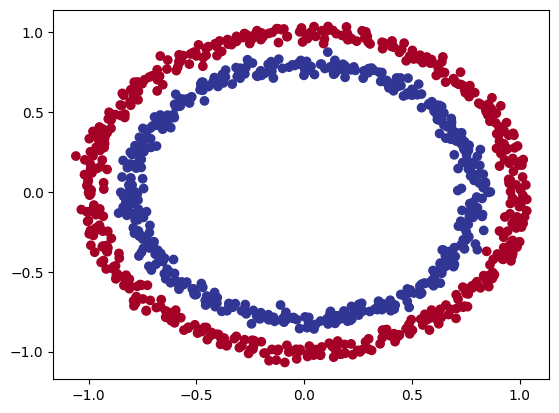

In [7]:
#visualiizingggg
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 input & output shapes
- mismatching shape error

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X_sample = X[0]
y_sample = y[0]
X_sample, y_sample


(array([0.75424625, 0.23148074]), np.int64(1))

### 1.2 data => tensors

In [10]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=44)
len(X_train), len(X_test)

(800, 200)

## 2. Building the model

In [12]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2.0 setup the model layers


In [13]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
untrained_preds = model_0(X_test.to(device))
print(f"first 10 predictions: {untrained_preds[:10]}")
print(f"first 10 labels{y_test[:10]}")

first 10 predictions: tensor([[ 0.0627],
        [-0.4274],
        [-0.0120],
        [-0.2532],
        [-0.4370],
        [ 0.0214],
        [ 0.0283],
        [ 0.0836],
        [-0.0632],
        [ 0.0770]], grad_fn=<SliceBackward0>)
first 10 labelstensor([1., 0., 0., 0., 1., 0., 1., 1., 1., 1.])


### 2.1 loss function & optimizer

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc


## 3. Train the model

### 3.1 logits -> probability -> labels

- logits: row probabilities of the classification, but not actual probabilities (not normalized, +,-, out of scope)

In [17]:
#logits
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0627],
        [-0.4274],
        [-0.0120],
        [-0.2532],
        [-0.4370]], grad_fn=<SliceBackward0>)

In [18]:
#prob
y_preds_prob = torch.sigmoid(y_logits)
y_preds_prob

tensor([[0.5157],
        [0.3947],
        [0.4970],
        [0.4370],
        [0.3925]], grad_fn=<SigmoidBackward0>)

In [19]:
#label
y_preds = torch.round(y_preds_prob)
y_preds_lbl = torch.round(torch.sigmoid(model_0(X_test.to(device))))
print(torch.eq(y_preds.squeeze(), y_test[:5]))
y_preds.squeeze()

tensor([ True,  True,  True,  True, False])


tensor([1., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

### 3.2 trainning & testing loop

In [20]:
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  #1. forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  #2. calc loss
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)
  #3. optim 0
  optimizer.zero_grad()

  #4. loss backward
  loss.backward()

  #5. optim
  optimizer.step()

  ##testing
  model_0.eval()

  with torch.inference_mode():
    #1. forward
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch%10==0:
    print(f"epoch:{epoch}, loss:{loss}, accuracy: {acc}, test loss: {test_loss}, test acc: {test_acc}")





epoch:0, loss:0.703854501247406, accuracy: 46.75, test loss: 0.6979816555976868, test acc: 50.0
epoch:10, loss:0.6992925405502319, accuracy: 48.0, test loss: 0.6940726637840271, test acc: 50.5
epoch:20, loss:0.697231650352478, accuracy: 48.625, test loss: 0.692798376083374, test acc: 52.5
epoch:30, loss:0.6961205005645752, accuracy: 48.875, test loss: 0.6925002336502075, test acc: 51.5
epoch:40, loss:0.6954222321510315, accuracy: 48.875, test loss: 0.6925768852233887, test acc: 51.5
epoch:50, loss:0.6949337124824524, accuracy: 49.0, test loss: 0.6927943229675293, test acc: 53.0
epoch:60, loss:0.694568395614624, accuracy: 48.875, test loss: 0.6930561065673828, test acc: 52.0
epoch:70, loss:0.6942841410636902, accuracy: 48.875, test loss: 0.6933207511901855, test acc: 53.5
epoch:80, loss:0.6940572261810303, accuracy: 49.0, test loss: 0.6935704946517944, test acc: 50.5
epoch:90, loss:0.6938729882240295, accuracy: 49.25, test loss: 0.6937983632087708, test acc: 50.5


## 4. predictions and eval

In [21]:
import requests
from pathlib import Path

if Path("helper functions.py").is_file():
  print("exist")

else:
  print("downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

  from helper_functions import plot_predictions, plot_decision_boundary


downloading


In [22]:
  from helper_functions import plot_predictions, plot_decision_boundary


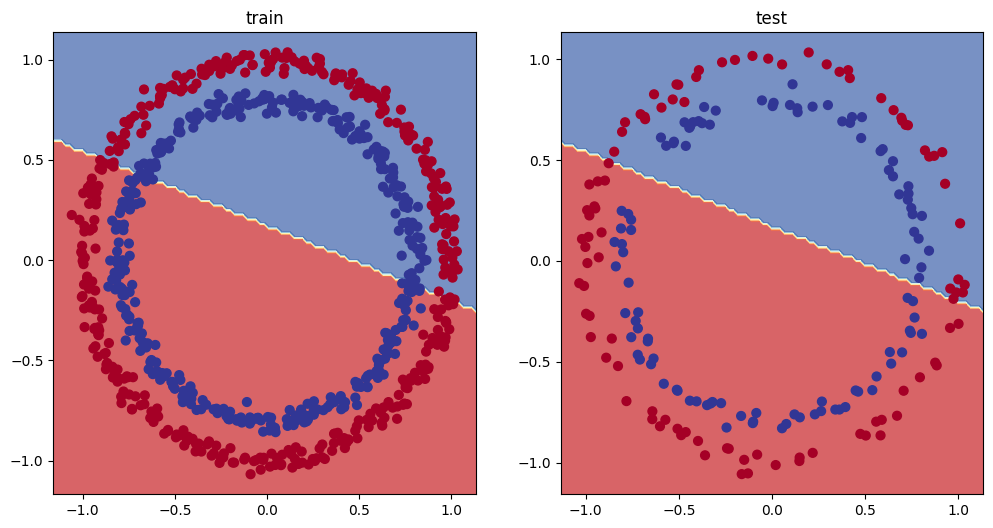

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. improving model

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)


In [26]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test)
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits.squeeze(), y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred.squeeze())

  if epoch %10 == 0:
    print(f"epoch: {epoch}, loss: {loss}, accuracy: {acc}, test loss: {test_loss}, test accuracy: {test_acc}")

epoch: 0, loss: 0.6938125491142273, accuracy: 50.5, test loss: 0.6946046948432922, test accuracy: 48.0
epoch: 10, loss: 0.693386971950531, accuracy: 50.5, test loss: 0.6939910650253296, test accuracy: 48.0
epoch: 20, loss: 0.6932209730148315, accuracy: 48.5, test loss: 0.6938367486000061, test accuracy: 45.0
epoch: 30, loss: 0.6931353807449341, accuracy: 40.875, test loss: 0.6938620209693909, test accuracy: 40.5
epoch: 40, loss: 0.6930789947509766, accuracy: 46.375, test loss: 0.6939603686332703, test accuracy: 43.5
epoch: 50, loss: 0.6930363178253174, accuracy: 46.0, test loss: 0.6940866708755493, test accuracy: 46.5
epoch: 60, loss: 0.6930021047592163, accuracy: 47.625, test loss: 0.6942209601402283, test accuracy: 43.5
epoch: 70, loss: 0.6929739117622375, accuracy: 49.5, test loss: 0.6943535804748535, test accuracy: 43.5
epoch: 80, loss: 0.6929506063461304, accuracy: 48.875, test loss: 0.6944801807403564, test accuracy: 43.0
epoch: 90, loss: 0.6929311156272888, accuracy: 49.625, tes

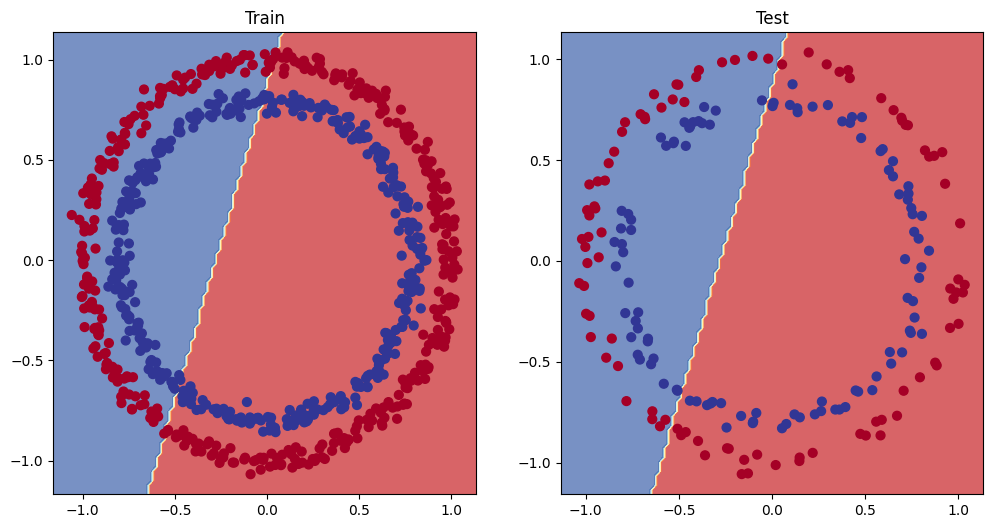

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 modeling straight line

In [28]:
#testing if the model can actually learn from any data
#creating linear data t see if the problem is in the linear function with non linear data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
train_split = int(0.8 * len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]


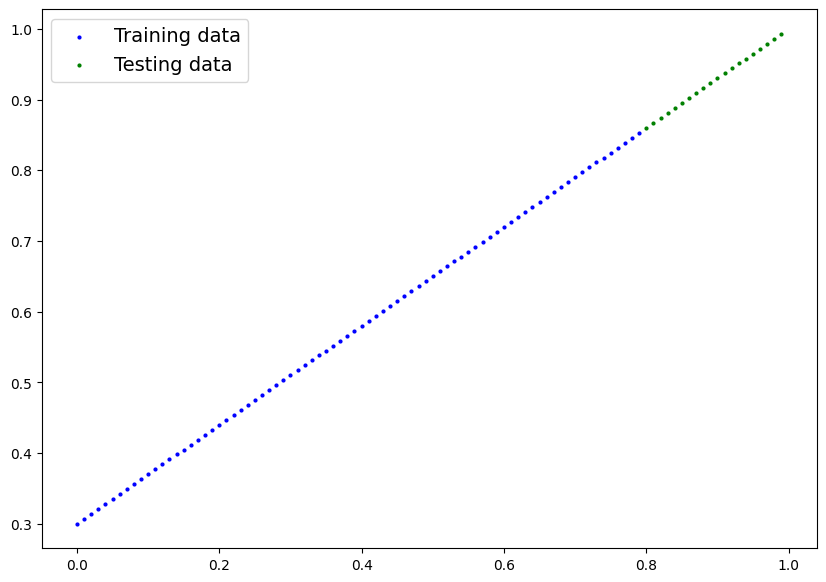

In [30]:
plot_predictions(train_data=X_train_reg,
                 train_labels = y_train_reg,
                 test_data = X_test_reg,
                 test_labels = y_test_reg)

### 5.2 adjusting model_1 to fit

In [31]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features = 10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr =0.1)

In [33]:
torch.manual_seed(42)
epochs = 2000
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_reg)

  loss = loss_fn(y_pred, y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_2.eval()

  with torch.inference_mode():
    test_pred = model_2(X_test_reg)
    test_loss = loss_fn(test_pred, y_test_reg)

  if epoch%100 ==0:
    print(f"epoch: {epoch}, train loss {loss}, test loss: {test_loss}")

epoch: 0, train loss 0.8926359415054321, test loss: 0.8438196182250977
epoch: 100, train loss 0.07422073185443878, test loss: 0.019162580370903015
epoch: 200, train loss 0.08664020150899887, test loss: 0.022539611905813217
epoch: 300, train loss 0.06836654990911484, test loss: 0.02559100091457367
epoch: 400, train loss 0.060776930302381516, test loss: 0.02017507329583168
epoch: 500, train loss 0.06589187681674957, test loss: 0.022953059524297714
epoch: 600, train loss 0.058377038687467575, test loss: 0.011864149942994118
epoch: 700, train loss 0.05583007261157036, test loss: 0.013097992166876793
epoch: 800, train loss 0.06821932643651962, test loss: 0.02060386911034584
epoch: 900, train loss 0.052875928580760956, test loss: 0.007454910781234503
epoch: 1000, train loss 0.052912164479494095, test loss: 0.00808783434331417
epoch: 1100, train loss 0.06195608526468277, test loss: 0.012569847516715527
epoch: 1200, train loss 0.06457378715276718, test loss: 0.018373141065239906
epoch: 1300, t

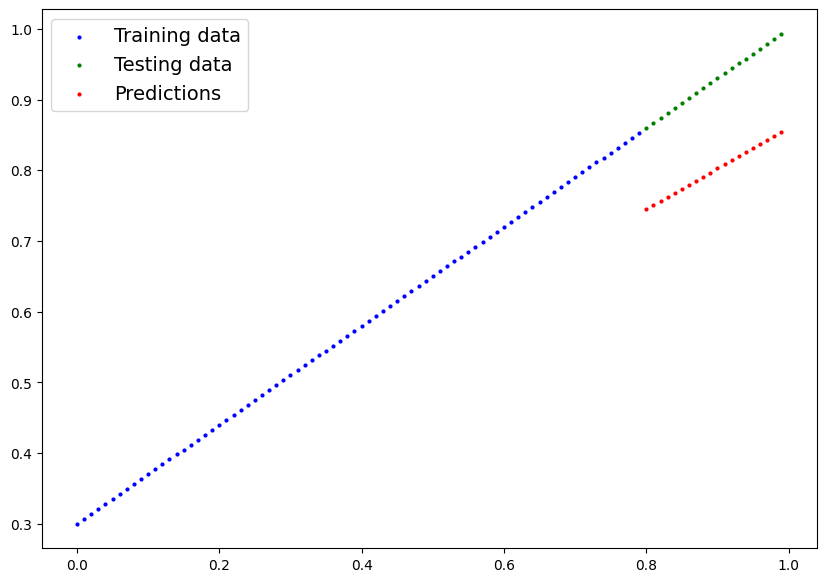

In [34]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_reg)

plot_predictions(train_data = X_train_reg.cpu(),
                 train_labels = y_train_reg.cpu(),
                 test_data = X_test_reg.cpu(),
                 test_labels = y_test_reg.cpu(),
                 predictions= y_preds.cpu())

## 6. non-linearity

### 6.1 recreating non-linear data

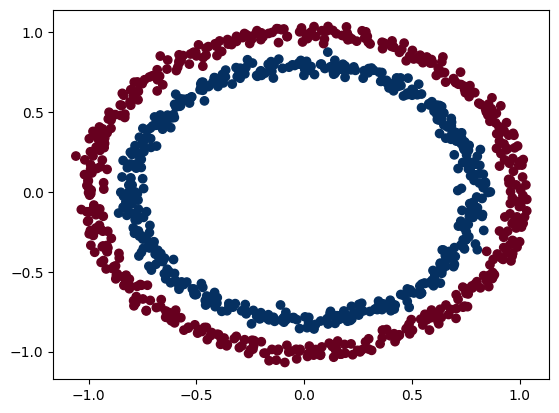

In [35]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000

X,y = make_circles(n_samples = 1000,
                   noise = 0.03,
                   random_state = 42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)

In [36]:
#splitting the data
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 building non-linear model

In [37]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu= nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [38]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

### 6.3 training non-linearity

In [47]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.64692, Accuracy: 74.12% | Test Loss: 0.65300, Test Accuracy: 71.50%
Epoch: 100 | Loss: 0.64488, Accuracy: 75.12% | Test Loss: 0.65139, Test Accuracy: 72.50%
Epoch: 200 | Loss: 0.64273, Accuracy: 75.88% | Test Loss: 0.64970, Test Accuracy: 72.00%
Epoch: 300 | Loss: 0.64047, Accuracy: 76.50% | Test Loss: 0.64793, Test Accuracy: 72.00%
Epoch: 400 | Loss: 0.63810, Accuracy: 77.50% | Test Loss: 0.64602, Test Accuracy: 73.50%
Epoch: 500 | Loss: 0.63562, Accuracy: 78.25% | Test Loss: 0.64402, Test Accuracy: 74.00%
Epoch: 600 | Loss: 0.63305, Accuracy: 78.62% | Test Loss: 0.64193, Test Accuracy: 74.00%
Epoch: 700 | Loss: 0.63034, Accuracy: 79.88% | Test Loss: 0.63974, Test Accuracy: 74.00%
Epoch: 800 | Loss: 0.62753, Accuracy: 80.50% | Test Loss: 0.63744, Test Accuracy: 75.00%
Epoch: 900 | Loss: 0.62458, Accuracy: 81.12% | Test Loss: 0.63496, Test Accuracy: 76.50%


In [48]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

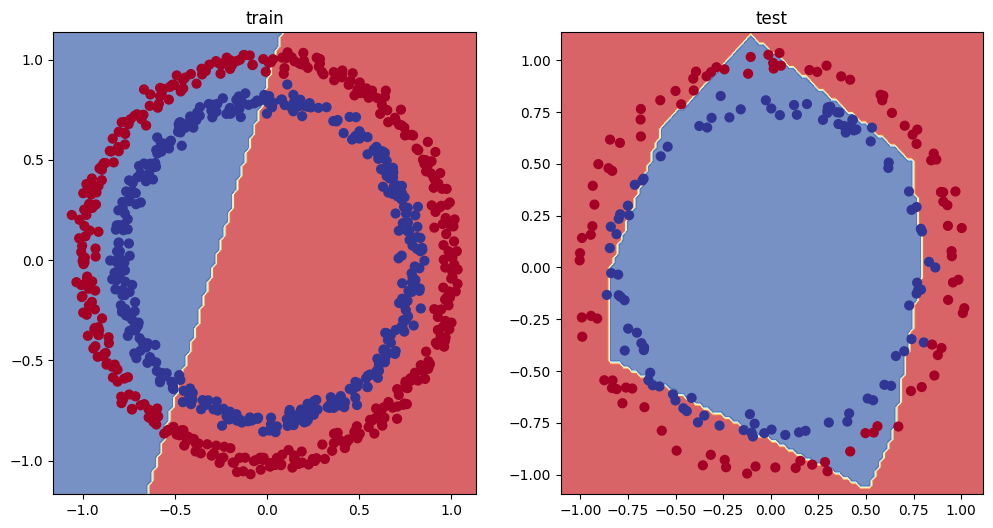

In [49]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. replacing non-linear activation functions

In [50]:
A = torch.arange(-10,10,1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

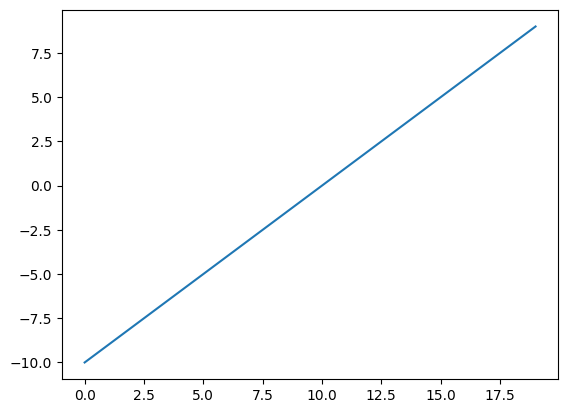

In [51]:
plt.plot(A)

In [52]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

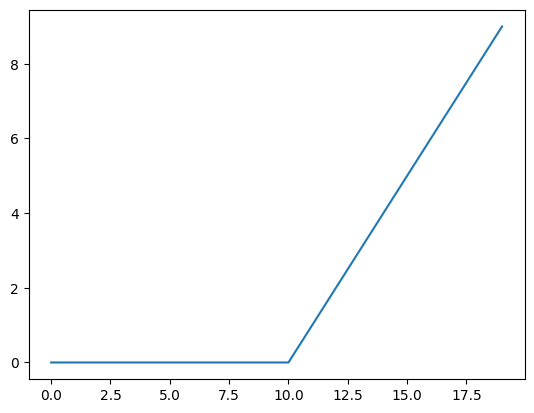

In [54]:
plt.plot(relu(A))

In [55]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

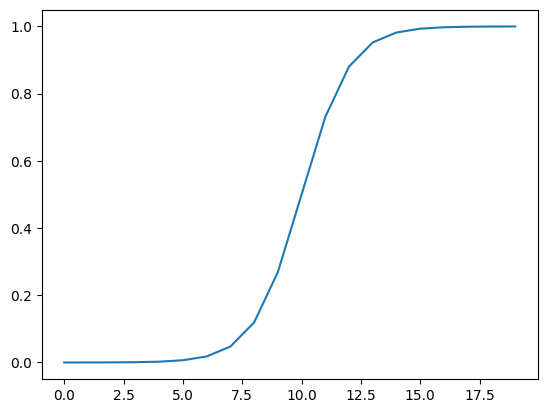

In [57]:
plt.plot(sigmoid(A))

## 8. putting things together

### 8.1 creating multi-class classification data

In [59]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


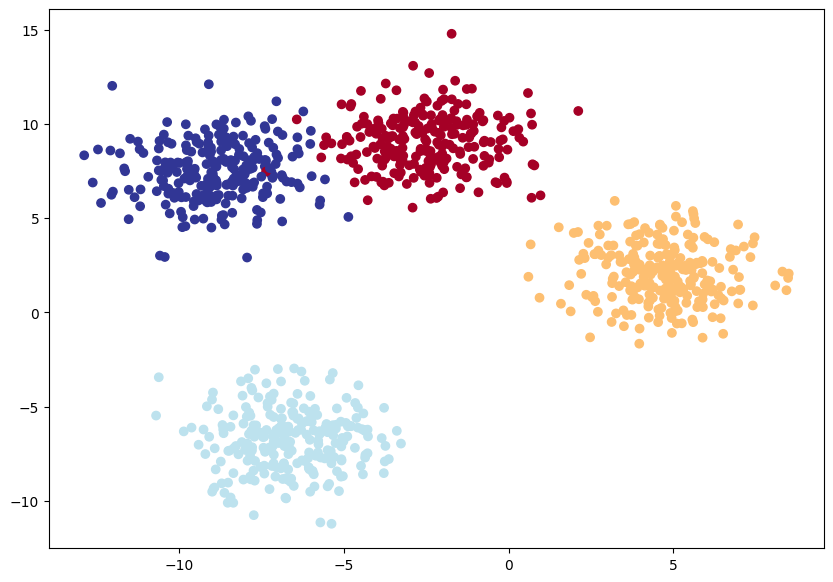

In [63]:
NUM_CLASSES =4
NUM_FEATURES=2
RANDOM_SEED=42

#1. creating ,ulti-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

#2. turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)
print(X_blob[:5], y_blob[:5])

#3. split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#4. PLOT
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 building multi-class classification model

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [68]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features))

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4




BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 loss & optim

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

### 8.4 predictions

In [70]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [71]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [73]:
# logits -> probabilities -> label
y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [74]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [75]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


### 8.5 trainning & testing loop => multi-class model

In [76]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)

In [77]:
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [78]:
for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim =1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true= y_blob_train,
                    y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred=test_pred)
  if epoch%10 == 0:
    print(f"epochs: {epoch}, loss: {loss}, accuracy: {acc}, test loss: {test_loss}, test accuracy: {test_acc}")

epochs: 0, loss: 1.0432370901107788, accuracy: 65.5, test loss: 0.5786145925521851, test accuracy: 95.5
epochs: 10, loss: 0.14397816359996796, accuracy: 99.125, test loss: 0.13037431240081787, test accuracy: 99.0
epochs: 20, loss: 0.08061711490154266, accuracy: 99.125, test loss: 0.07216108590364456, test accuracy: 99.5
epochs: 30, loss: 0.059235941618680954, accuracy: 99.125, test loss: 0.05133284628391266, test accuracy: 99.5
epochs: 40, loss: 0.048919182270765305, accuracy: 99.0, test loss: 0.04098135977983475, test accuracy: 99.5
epochs: 50, loss: 0.04294963926076889, accuracy: 99.0, test loss: 0.03486066684126854, test accuracy: 99.5
epochs: 60, loss: 0.03909869119524956, accuracy: 99.0, test loss: 0.03083428367972374, test accuracy: 99.5
epochs: 70, loss: 0.03642875701189041, accuracy: 99.0, test loss: 0.027988376095891, test accuracy: 99.5
epochs: 80, loss: 0.03448032587766647, accuracy: 99.0, test loss: 0.025870509445667267, test accuracy: 99.5
epochs: 90, loss: 0.0330028831958

### 8.6 making & evaluating pred w multi-class

In [79]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5919, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [80]:
y_pred_probs = torch.softmax(y_logits, dim=1)

In [81]:
y_preds = y_preds_prob.argmax(dim=1)

In [85]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = y_pred_probs.argmax(dim=1)

print(f"predictions: {y_preds[:10]}\nlabels: {y_blob_test[:10]}")
print(f"accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
accuracy: 99.5%


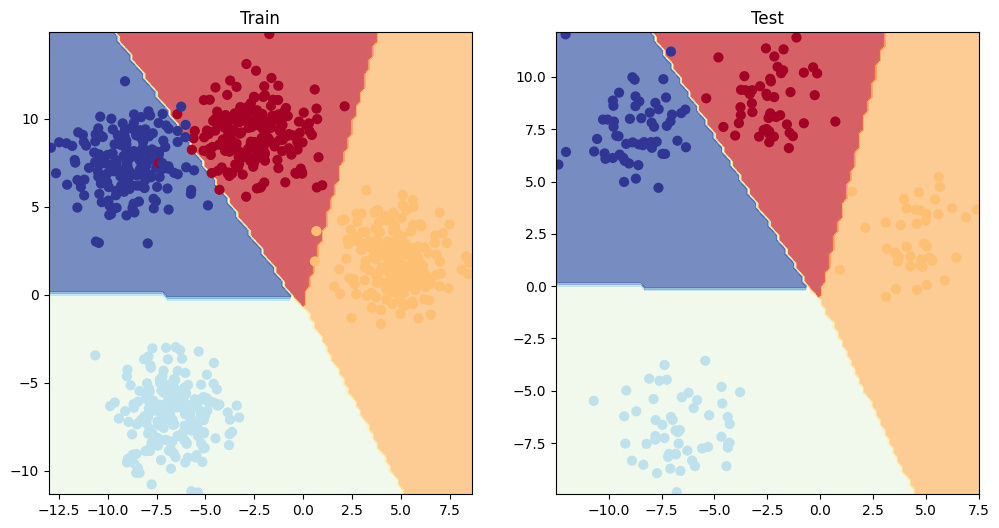

In [86]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics==0.9.3
  from torchmetrics import Accuracy

tourch_acc = Accuracy(task="multiclass", num_classes=4).to(device)
tourch_acc(y_preds, y_blob_test)
